In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from graph.graphutils import showGraph,showComparsionGraph
from dateutil.parser import parse
from utils.converterutils import addHeader
from utils.dfUtils import getDataFrame
import warnings
warnings.filterwarnings("ignore")
import time
import datetime
import matplotlib
import matplotlib.pyplot as plt

In [2]:
## Load Test Data

In [3]:
lstm = pd.read_csv('../../test_data/wind_direction_data.csv', index_col='datetime', parse_dates=['datetime'])
lstm.head(2)

,y
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,20.0


In [4]:
## Convert to data fromat and plot graph

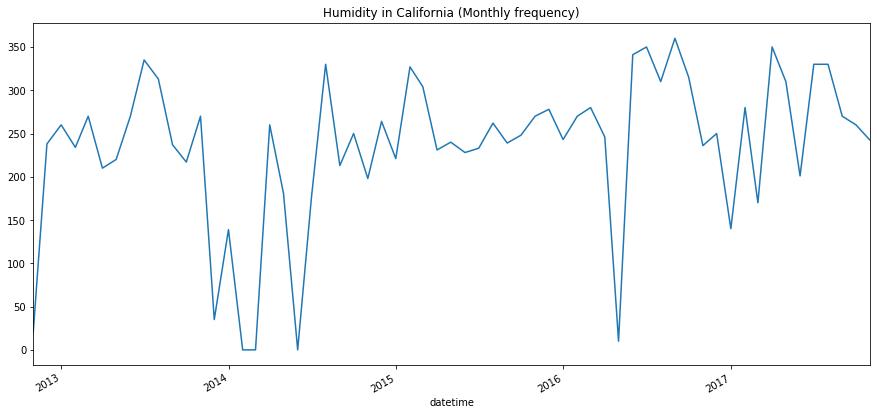

In [5]:
plt.figure(figsize=(15,7))
lstm["y"].asfreq('M').plot()
plt.title('Humidity in California (Monthly frequency)')
plt.show()

In [6]:
## Predict Model

In [7]:
from  mlalgms.evaluator import ts_train_test_split

In [8]:
train_lstm,test_lstm = ts_train_test_split(lstm,0.75)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_lstm['y'] = scaler.fit_transform(train_lstm) 
test_lstm['y'] =  scaler.fit_transform(test_lstm) 

In [10]:
## Data preparation, create, compile and predict model

In [11]:
from mlalgms.kerasdeeplearning import create_datasets,createModel, compileModel, predictModel
from mlalgms.tsutils import mergeResult
from mlalgms.evaluator import mape

Using TensorFlow backend.


In [12]:
LAG = 3
HORIZON =1
y_train_lstm , X_train_lstm = create_datasets (train_lstm,lag=LAG)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], LAG, 1)
y_test_lstm, X_test_lstm = create_datasets (test_lstm,lag=LAG)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], LAG, 1)

In [13]:
LATENT_DIM = 5
start = time.time()
model = createModel(mymodel='GRU', latentDim=LATENT_DIM, lag=LAG, layer=1)
print ("Time Spent", time.time() - start, "seconds.")
model.summary()

Time Spent 0.18276000022888184 seconds.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [14]:
start = time.time()
historical_lstm = compileModel(model,X_train_lstm,y_train_lstm, batchSize=100,epochs=200,learning_rate = 0.01, validation_split_rate =0.15)
print ("Time Spent", time.time() - start, "seconds.")

Train on 28845 samples, validate on 5091 samples
Epoch 1/200
28845/28845 [==============================] - 2s 54us/step - loss: 0.1136 - val_loss: 0.0585
Epoch 2/200
28845/28845 [==============================] - 1s 33us/step - loss: 0.0575 - val_loss: 0.0573
Epoch 3/200
28845/28845 [==============================] - 1s 30us/step - loss: 0.0571 - val_loss: 0.0571
Epoch 4/200
28845/28845 [==============================] - 1s 30us/step - loss: 0.0571 - val_loss: 0.0571
Time Spent 5.02612566947937 seconds.


In [15]:
start = time.time()
predictions_lstm = predictModel(model, X_test_lstm)
print ("Time Spent", time.time() - start, "seconds.")

Time Spent 0.45815610885620117 seconds.


In [16]:
predictions_lstm.shape

(11310, 1)

In [17]:
merge_lstm_df = mergeResult(test_lstm,y_test_lstm,predictions_lstm)

In [18]:
merge_lstm_df.head(2)

,timestamp,h,prediction,actual
0,2016-08-15 16:00:00,t+1,0.397788,0.086111
1,2016-08-15 17:00:00,t+1,0.282332,0.008333


In [19]:
## Calculate Actual vs Prediction mean absolute percentage error

In [20]:
mape(merge_lstm_df['actual'], merge_lstm_df['prediction'])

125.38435764949128

## Actual vs Prediction Graph

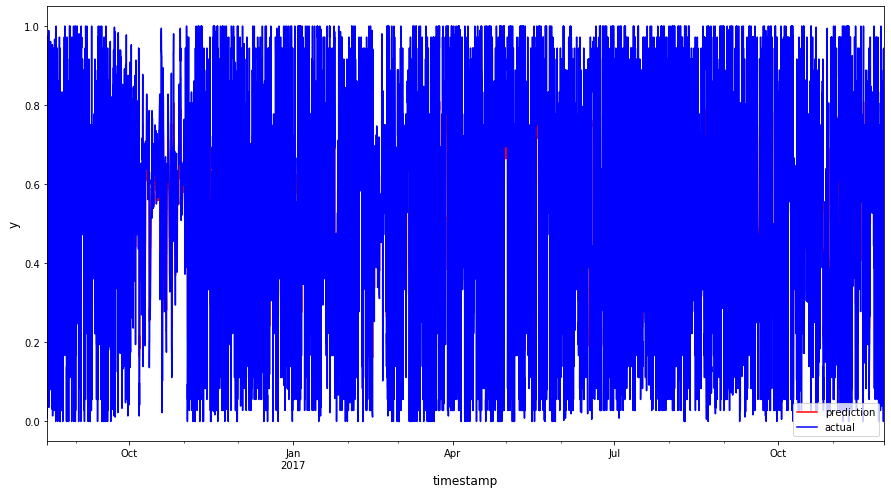

In [21]:
showComparsionGraph(merge_lstm_df)